# Ramp-up Kaggle  - House Prices: EDA, Regression, Pipeline  

### Intro
The this kernel is to get acquainted with Kaggle & experiment with eda, feature enginering & pipelining.

Many thanks to the guys in the credits for their great kernels!

### Credits
* [House Prices EDA](https://www.kaggle.com/dgawlik/house-prices-eda) by Dominik Gawlik

* [A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) by Julien Cohen-Solal

* [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) by Alexandru Papiu

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
#import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#warnings.filterwarnings('ignore')

## Load the data

In [227]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Preprocessing

In [228]:
# Check for duplicates
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("TRAIN\n# entries: " + str(idsTotal) + "\n# duplicates: " + str(idsDupli))
idsUnique = len(set(test.Id))
idsTotal = test.shape[0]
idsDupli = idsTotal - idsUnique
print("\nTEST\n# entries: " + str(idsTotal) + "\n# duplicates: " + str(idsDupli))

# Drop Id column
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

TRAIN
# entries: 1460
# duplicates: 0

TEST
# entries: 1459
# duplicates: 0


In [229]:
# Log transform the target for official scoring
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

### Missing data

In [230]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageType       81  0.055479
GarageCond       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
GarageYrBlt      81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
RoofMatl          0  0.000000

In [231]:
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)

In [232]:
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
#No extra feature = value of the extra feature is O
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)

In [233]:
# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("No")

In [234]:
# Fence : data description says NA means "no Fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")

In [235]:
# FireplaceQu : data description says NA means "no FireplaceQu"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)

In [236]:
#LotFrontage - It means that the property is not visible from the street as it is in a back lo
# see the following interesting discussion on Zillow - 
#https://www.zillow.com/advice-thread/How-to-value-a-home-with-no-street-frontage/325833/
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna("No")

#GarageCars=0=No Garage : 81


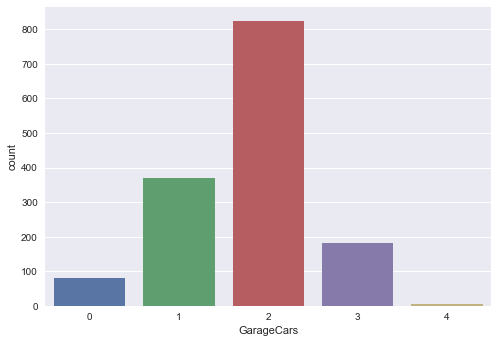

In [237]:
#GarageCars,GarageArea
sns.countplot(x="GarageCars",data=train)
print("#GarageCars=0=No Garage : " + str(len(train[train['GarageCars']==0])))

#GarageArea=0=No Garage : 81


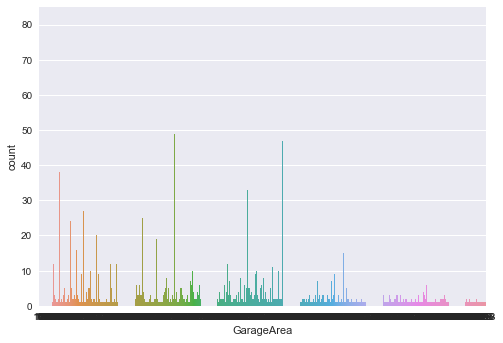

In [238]:
#GarageArea
sns.countplot(x="GarageArea",data=train)
print("#GarageArea=0=No Garage : " + str(len(train[train['GarageArea']==0])))

In [239]:
#GarageType,GarageCond,GarageFinish,GarageQual,GarageCars,GarageArea
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)

In [240]:
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA \means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")

In [241]:
#MasVnrArea,MasVnrType
print("#MasVnrType= None: " + str(len(train[train['MasVnrType']=='None'])) )
print("#MasVnrArea= 0: " + str(len(train[train['MasVnrArea']==0])) )
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)

#MasVnrType= None: 864
#MasVnrArea= 0: 861


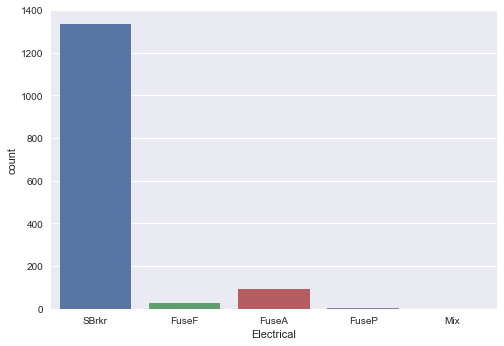

In [242]:
#Eletrical
sns.countplot(x="Electrical",data=train)

In [243]:
#Electrical - fill with the most common value = SBrkr standard Circuit Breakers & Romex
train.loc[:, "Electrical"] = train.loc[:, "Electrical"].fillna("SBrkr")

In [244]:
# THANKS JULIEN for that!!! Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [245]:
# Encode some categorical features as ordered numbers when there is information in the order
# I have started the rankings from 1 & not from 0. 
#By Starting from 1, the absence of the feature does not impact the result when I create features by multiplication
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 1, "Po" : 2, "Fa" : 3, "TA" : 4, "Gd" : 5, "Ex" : 6},
                       "BsmtExposure" : {"No" : 1, "Mn" : 2, "Av": 3, "Gd" : 4},
                       "BsmtFinType1" : {"No" : 1, "Unf" : 2, "LwQ": 3, "Rec" : 4, "BLQ" : 5, 
                                         "ALQ" : 6, "GLQ" : 7},
                       "BsmtFinType2" : {"No" : 1, "Unf" : 2, "LwQ": 3, "Rec" : 4, "BLQ" : 5, 
                                         "ALQ" : 6, "GLQ" : 7},
                       "BsmtQual" : {"No" : 1, "Po" : 2, "Fa" : 3, "TA" : 4, "Gd" : 5, "Ex" : 6},
                       "ExterCond" : { "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "ExterQual" : { "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 1, "Po" : 2, "Fa" : 3, "TA" : 4, "Gd" : 5, "Ex" : 6},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 1, "Po" : 2, "Fa" : 3, "TA" : 4, "Gd" : 5, "Ex" : 6},
                       "GarageQual" : {"No" : 1, "Po" : 2, "Fa" : 3, "TA" : 4, "Gd" : 5, "Ex" : 6},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 1, "P" : 2, "Y" : 3},
                       "PoolQC" : {"No" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
                        "Fence" : {"GdPrv":5,"MnPrv":4,"GdWo":3,"MnWw":2,"No":1}}
                      
                     )

### Features engineering ohohoh

In [246]:
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]

In [247]:
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]

In [248]:
#ratio price/lot size
train['LotPricePerSqrFeet']=train['SalePrice']/(1.0*train['LotArea'])

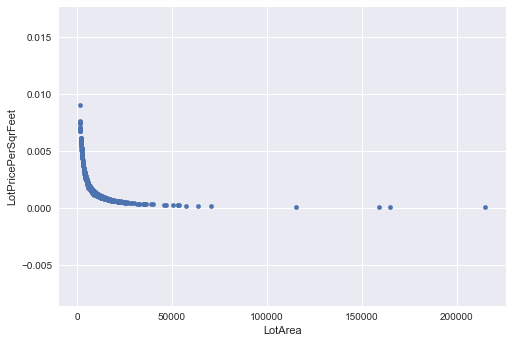

In [249]:
#scatter plot LotPricePerSqrFeet/LotArea
var = 'LotArea'
data = pd.concat([train['LotPricePerSqrFeet'], train[var]], axis=1)
data.plot.scatter(x=var, y='LotPricePerSqrFeet');

### Encoding & normalizing

In [250]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
#quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
print ("#quantitative" , len(quantitative))
print ("#qualitative" , len(qualitative))

#quantitative 65
#qualitative 26


In [251]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train[quantitative].isnull().values.sum()))
train[quantitative] = train[quantitative].fillna(train[quantitative].median())
print("Remaining NAs for numerical features in train : " + str(train[quantitative].isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [252]:
#reduce skewedness
from scipy.stats import skew

qual_feat_train= train.dtypes[train.dtypes != "object"].index
qual_feat_test= test.dtypes[test.dtypes != "object"].index

#calculate skewedness
train_skewed_calc = train[qual_feat_train].apply(lambda x: skew(x.dropna()))
test_skewed_calc = test[qual_feat_test].apply(lambda x: skew(x.dropna()))

#get the indexes of the data to transform
train_skewed_idx = train_skewed_calc[train_skewed_calc > 0.75].index
test_skewed_idx = test_skewed_calc[test_skewed_calc > 0.75].index

#normalize features
train[train_skewed_idx] = np.log1p(train[train_skewed_idx])
test[test_skewed_idx] = np.log1p(test[test_skewed_idx])

In [253]:
# Create dummy features for categorical values via one-hot encoding
qual_encoded = pd.get_dummies(train[qualitative])
train.drop(train[qualitative],axis=1,inplace=True)
train = train.join(qual_encoded)

### Correlation
I will run 3 sorts of analysis:
* Pandas correlation: pearson, spearman, kendall
* Spearman correlation
* Heatmap

Let me explain why I have first encoded the qualitative features & then run the correlation. My idea was that Neighborhood should heavily influence the price. After correlation I have surprisingly noticed that the price seems to be mainly driven by the quality of the house. Something to keep an eye on during modeling.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


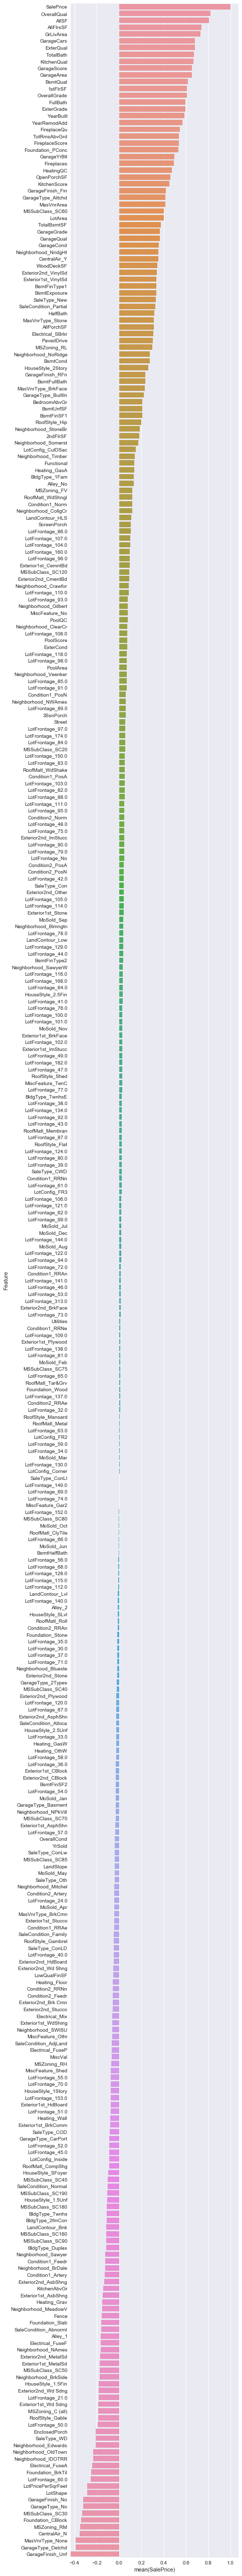

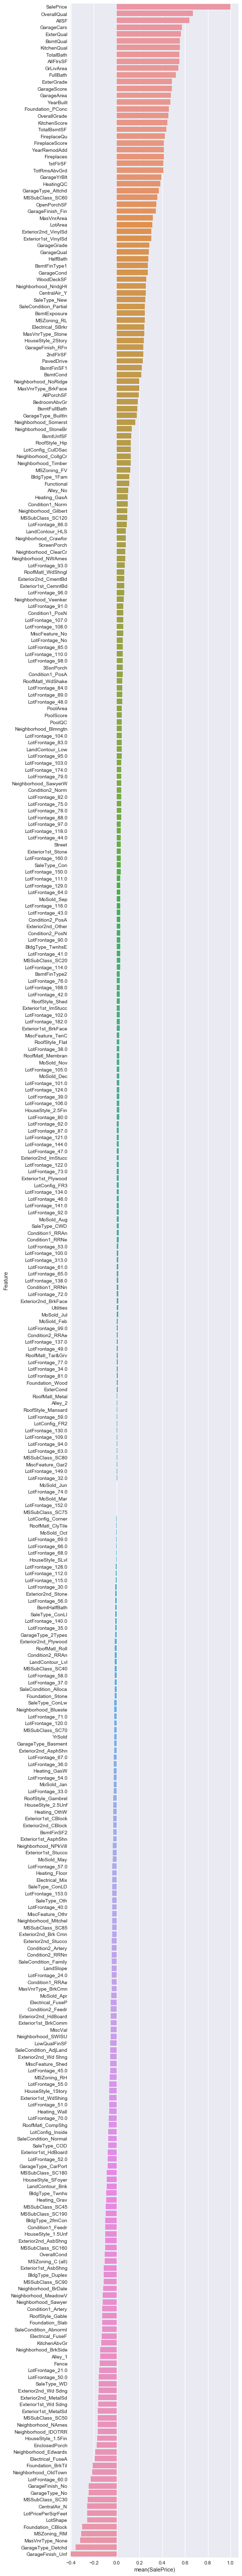

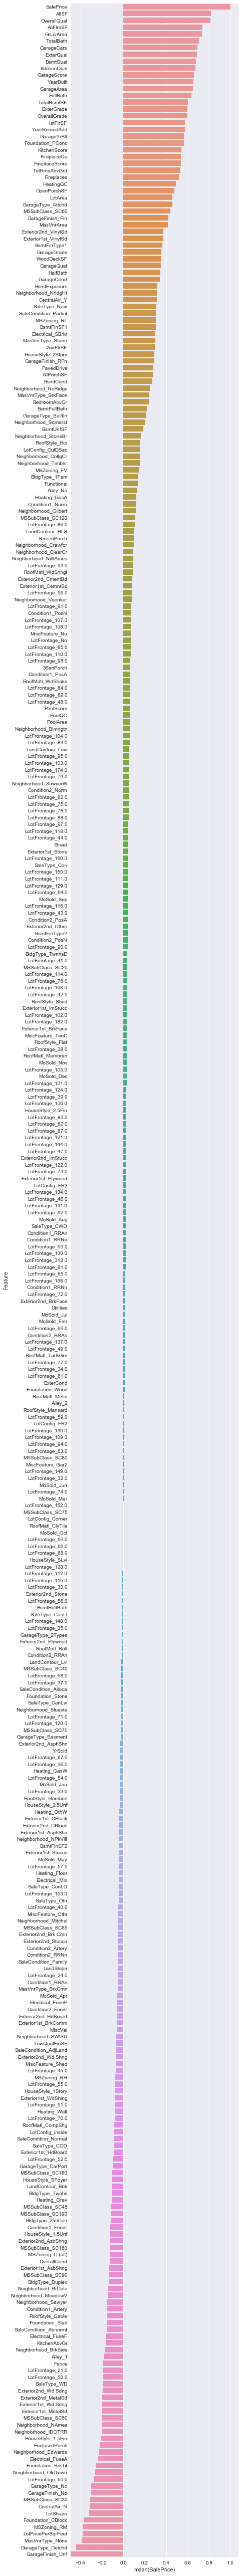

In [255]:
def g_corr(method,frame):
    corr = frame.corr(method)
    spr = pd.DataFrame()
    spr['SalePrice'] = corr.loc["SalePrice"].transpose()
    spr['Feature']=spr.index.get_values()
    plt.figure(figsize=(6, 0.25*len(spr.index.get_values())))
    spr.sort(columns='SalePrice', ascending = False,inplace = True)
    sns.barplot(data=spr, y='Feature',x='SalePrice', orient='h')

g_corr('pearson',train)
g_corr('kendall',train)
g_corr('spearman',train)

### Outliers
We are dealing with house prices. I will look 1st how properties are distributed against sales prices.

I am going to use LotArea (Lot size in square feet) instead of GrLivArea (Above grade (ground) living area square feet) as GrLivArea includes just the house & not the rest, like ground, garages etc...
See the following articles for reference:
https://definedterm.com/above_grade_living_area_total_square_feet
http://www.findwell.com/blog/selling-a-home/how-much-does-lot-size-impact-the-price-of-my-home/

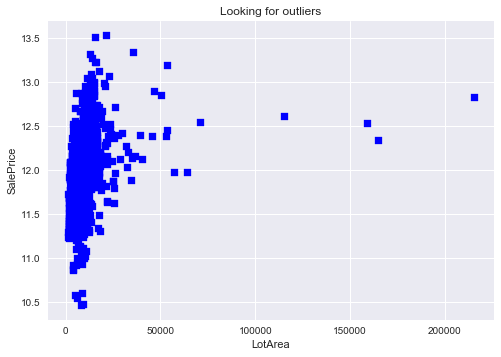

In [19]:
plt.scatter(train.LotArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.show()

Let's exclude properties larger than 5K sqrt feet.

In [21]:
train = train[train.LotArea < 5000]

Let's look for more outliers with OneClassSVM

## Target
### Summary

In [6]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Target Distribution

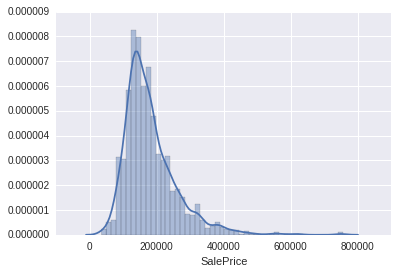

In [7]:
sns.distplot(train['SalePrice'])
#Flexibly plot a univariate distribution of observations.
#This function combines the matplotlib hist function (with automatic calculation of a good default bin size) 
#with the seaborn kdeplot() and rugplot() functions. 
#It can also fit scipy.stats distributions and plot the estimated PDF over the data.
#KDE https://en.wikipedia.org/wiki/Kernel_density_estimation

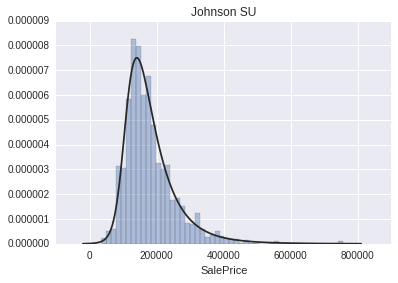

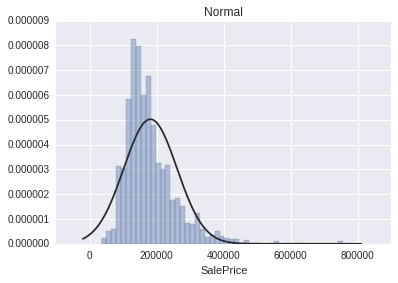

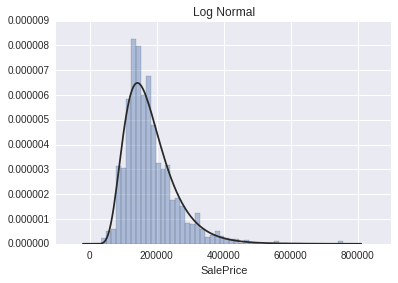

In [8]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

### Note
Target does not follow the normal distribution. Lognormal & Johnson seem to be a better fit.

## Features
### Qualitative/Quantitative

In [29]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
#quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [30]:
print ("#quantitative" , len(quantitative))
print ("#qualitative" , len(qualitative))

#quantitative 65
#qualitative 26


### Quantitative features distribution

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


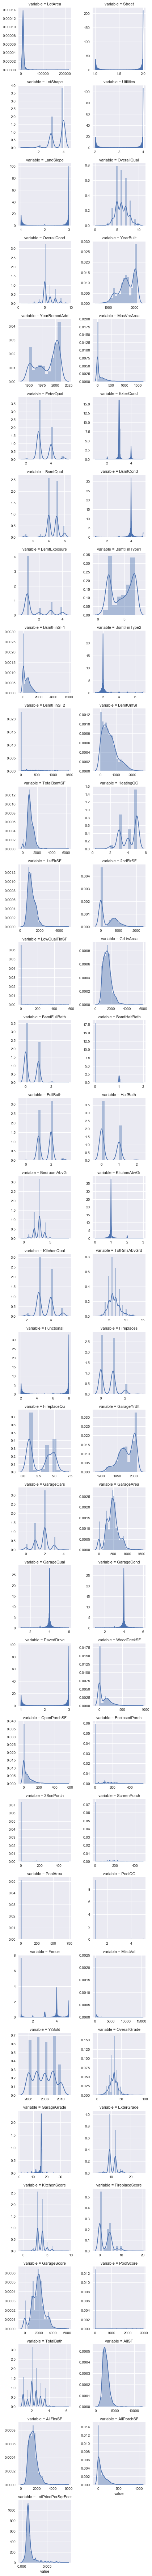

In [31]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

### Note 
Quantitative features do not follow the normal distr. 

Reduce skewedness by transforming the variables by taking log(feature + 1) 


In [32]:
from scipy.stats import skew

qual_feat_train= train.dtypes[train.dtypes != "object"].index
qual_feat_test= test.dtypes[test.dtypes != "object"].index

#calculate skewedness
train_skewed_calc = train[qual_feat_train].apply(lambda x: skew(x.dropna()))
test_skewed_calc = test[qual_feat_test].apply(lambda x: skew(x.dropna()))

#get the indexes of the data to transform
train_skewed_idx = train_skewed_calc[train_skewed_calc > 0.75].index
test_skewed_idx = test_skewed_calc[test_skewed_calc > 0.75].index

#normalize features
train[train_skewed_idx] = np.log1p(train[train_skewed_idx])
test[test_skewed_idx] = np.log1p(test[test_skewed_idx])


In [33]:
train_skewed_idx

Index(['LotArea', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath',
       'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal',
       'ExterGrade', 'KitchenScore', 'FireplaceScore', 'PoolScore', 'AllSF',
       'AllFlrsSF', 'AllPorchSF', 'LotPricePerSqrFeet'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


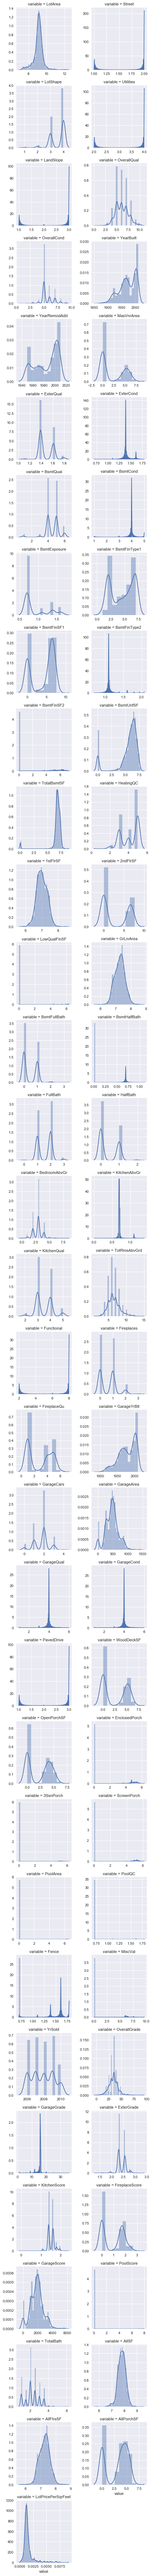

In [34]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

### Qualitative features

**1st Visualize the distribution of each feature values**

Not standard EDA. I want to understand how diverse is the data

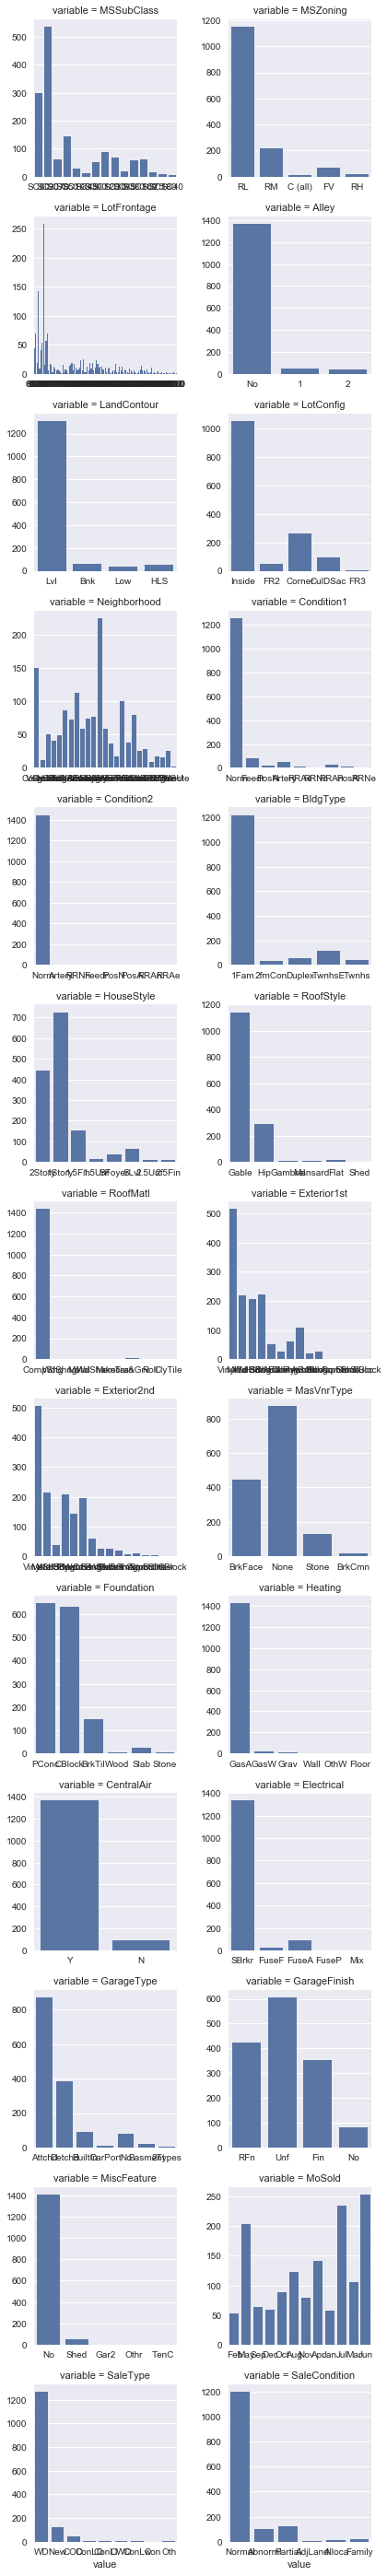

In [35]:
f = pd.melt(train, value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.countplot, "value")

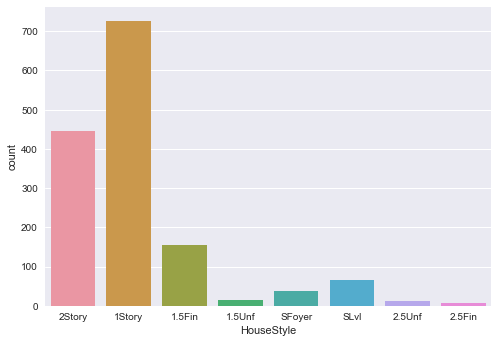

In [36]:
sns.countplot(x="HouseStyle",data=train)

### Note
We are looking mostly at 1 or 2 stories houses.
Looking at the features that are meant to score a particular catacteristic of the house, you can see that the dominating values are "TA=typical/avg" & "Gd=good". This does really add too much info & differentiation at 1st sight. Need to observe whether the features are knocked out by Lasso & random forest.

**Visualize the distribution of the sales price against the categorical features**

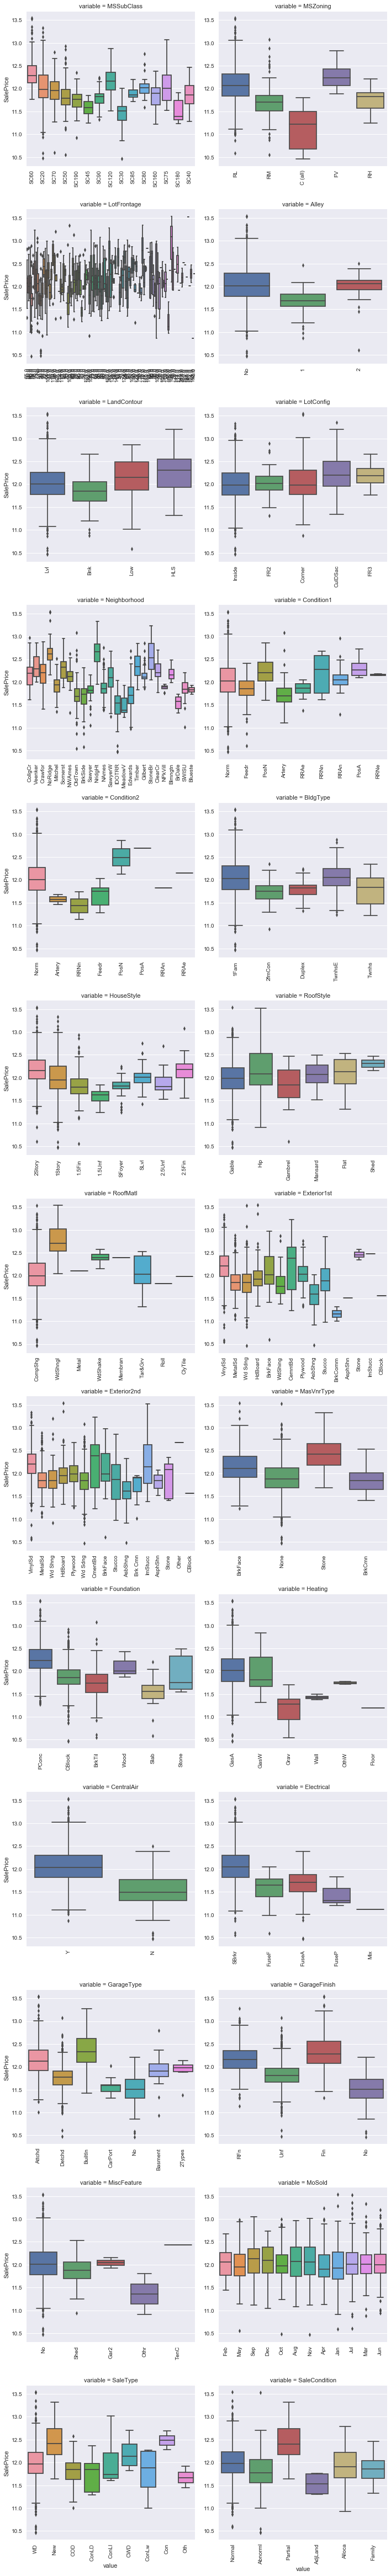

In [37]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")


**Put together feature distribution & sales price distribution against each feature**
This should help me getting a better qualitative understanding of which features drive the price

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


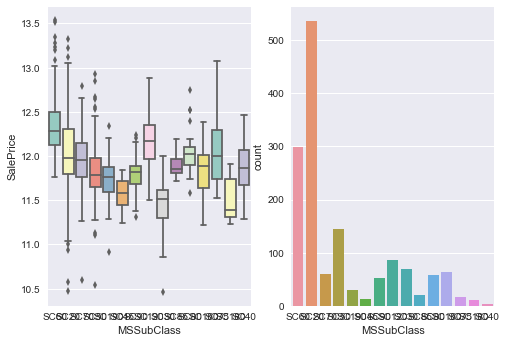

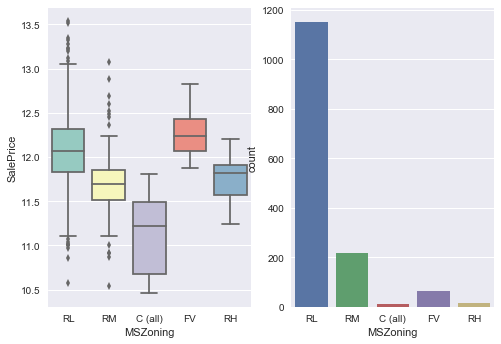

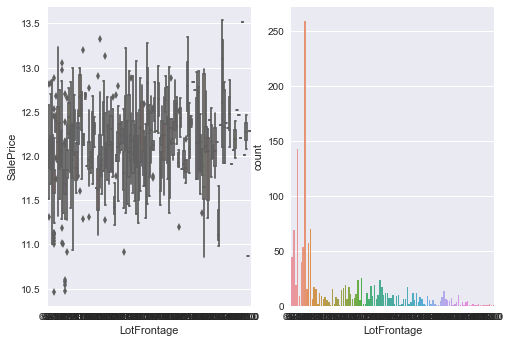

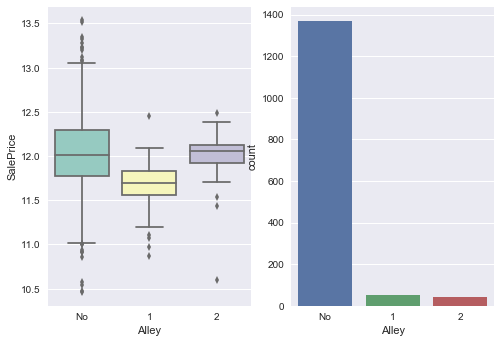

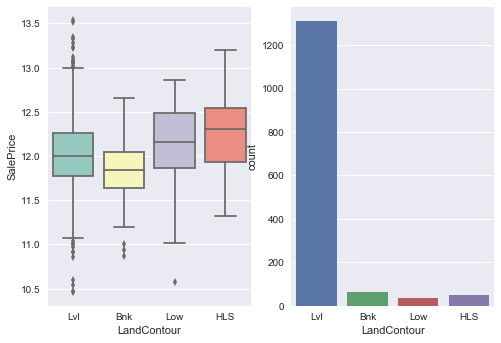

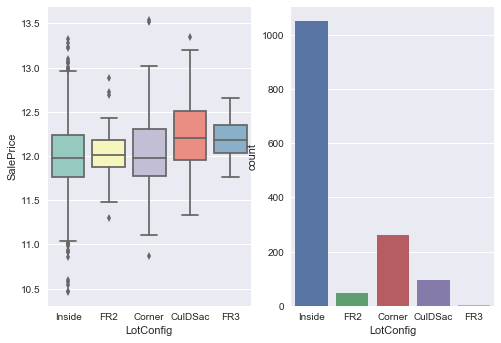

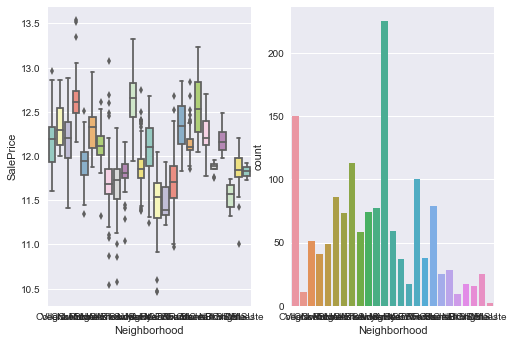

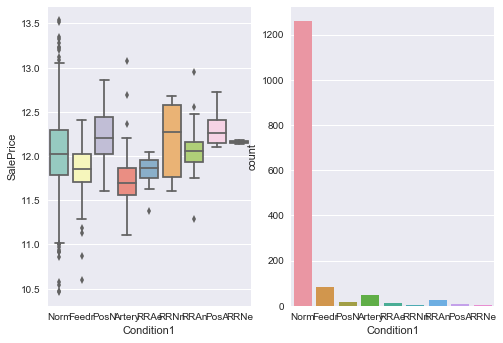

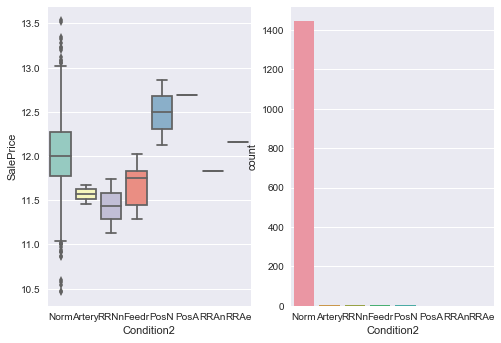

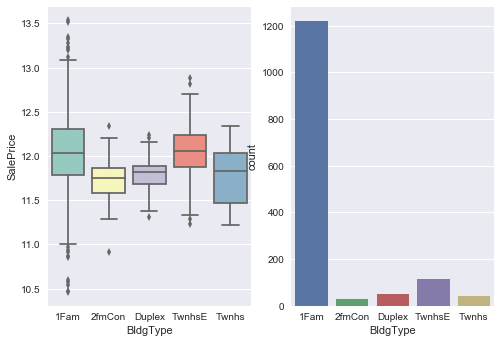

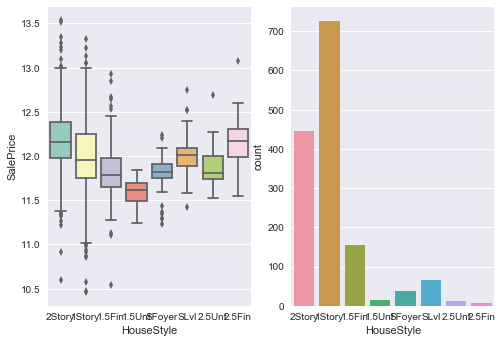

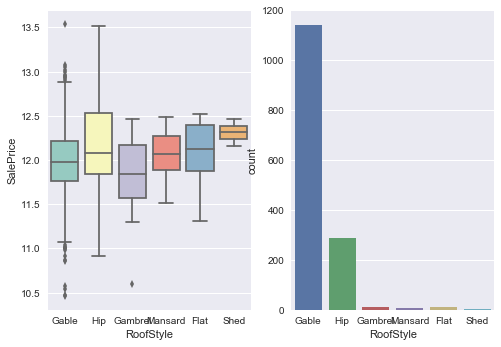

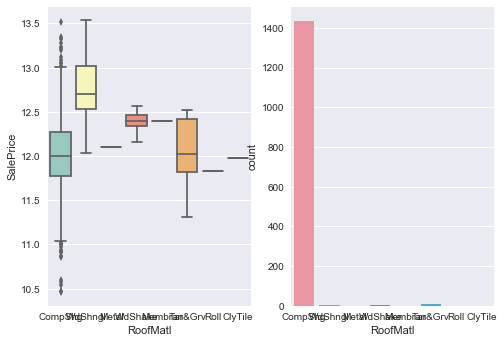

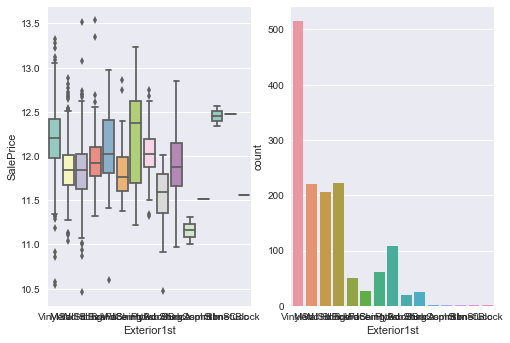

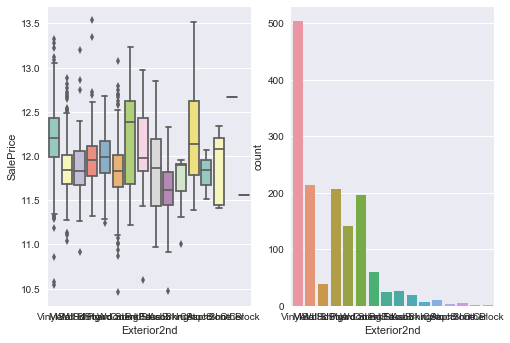

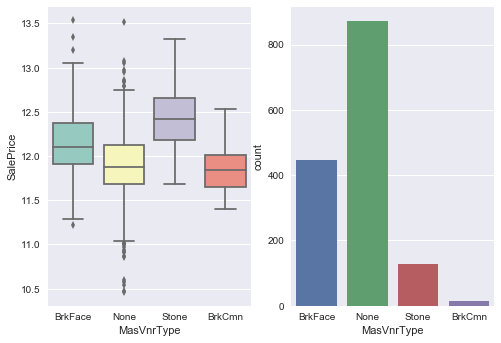

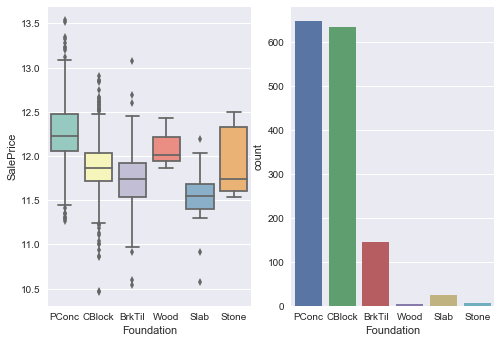

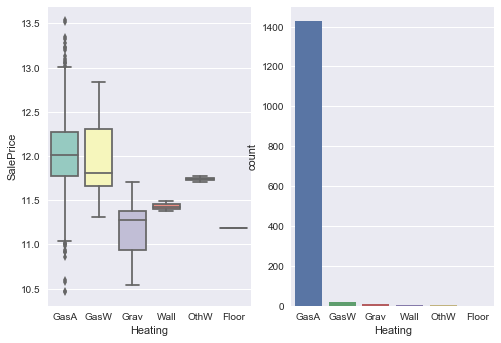

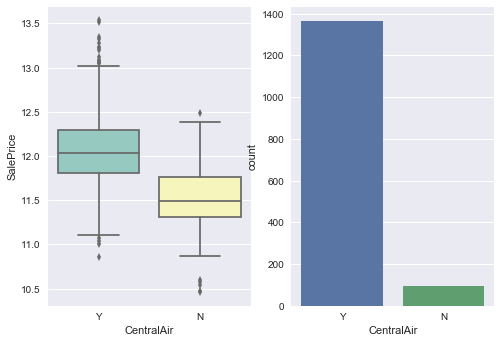

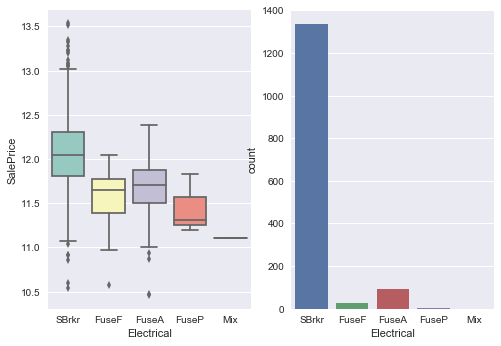

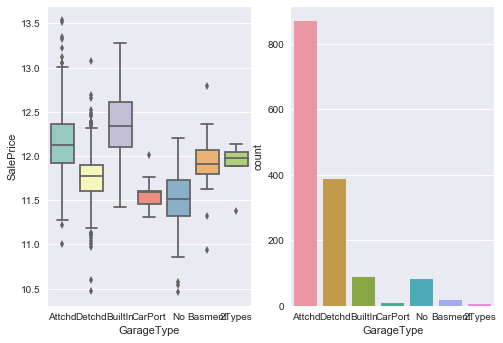

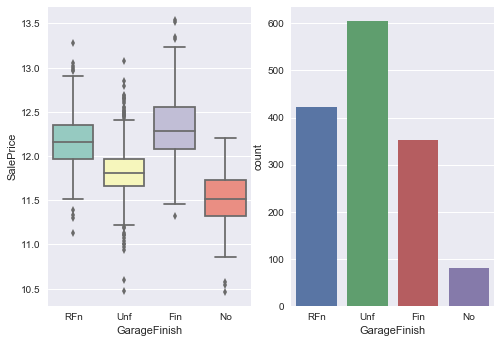

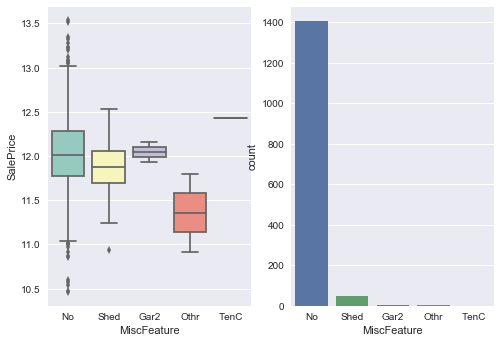

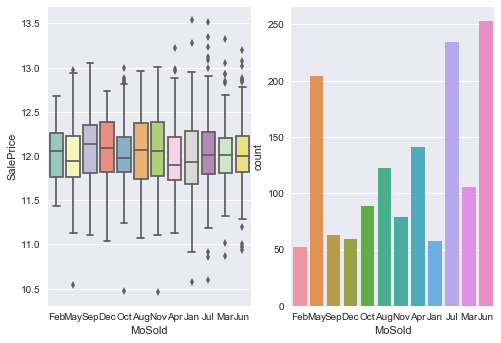

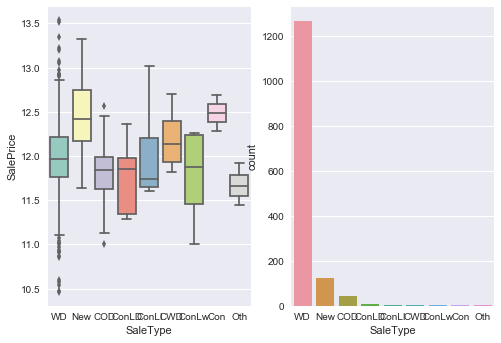

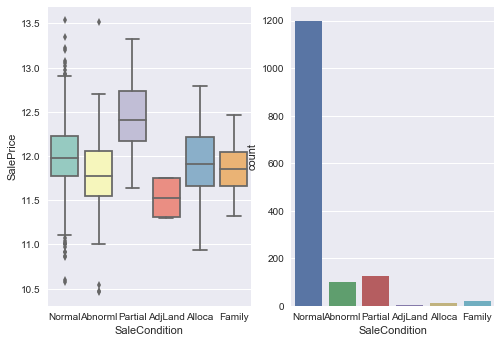

In [38]:
for feature in qualitative:
    fig, ax =plt.subplots(1,2)
    sns.boxplot(train[feature],train['SalePrice'] ,ax=ax[0],palette="Set3")
    sns.countplot(train[feature], ax=ax[1])
    fig.show()

In [40]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSSubClass_E', 'MSZoning_E', 'LotFrontage_E', 'Alley_E', 'LandContour_E', 'LotConfig_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'Foundation_E', 'Heating_E', 'CentralAir_E', 'Electrical_E', 'GarageType_E', 'GarageFinish_E', 'MiscFeature_E', 'MoSold_E', 'SaleType_E', 'SaleCondition_E']


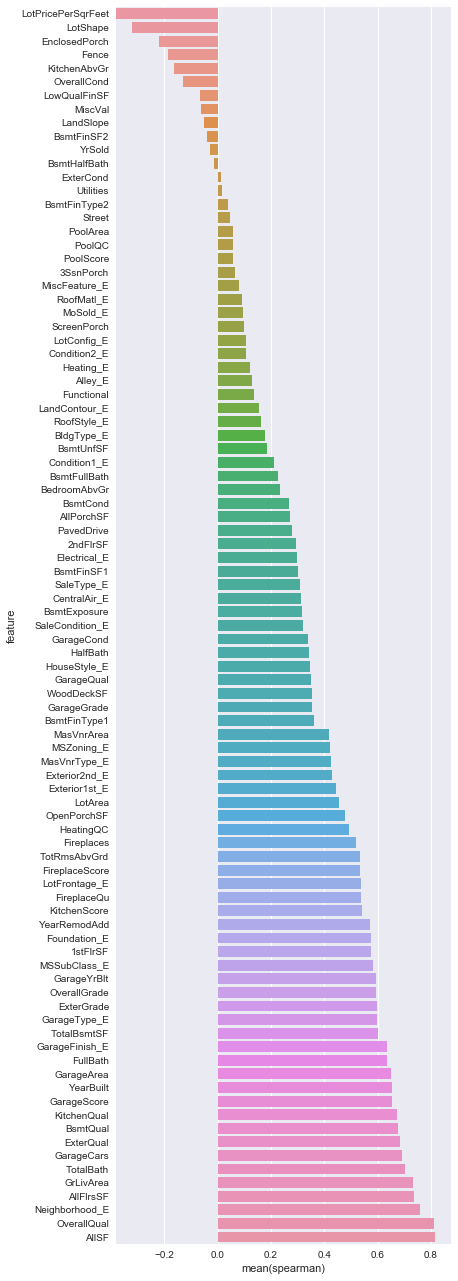

In [41]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, features)

In [45]:
type(features)

pandas.indexes.base.Index